# Identify & Track Marine Heatwaves using `spot_the_blOb`

## Processing Steps:
1. Fill holes in the binary data, using `dask_image.ndmorph` -- up to `R_fill` cells in radius.
2. Filter out small objects -- area less than the `area_filter_quartile` of the distribution of objects.
3. Identify objects in the binary data, using `dask_image.ndmeasure`.
4. Manually connect objects across time, applying Sun et al. 2023 criteria:
    - Connected Blobs must overlap by at least `overlap_threshold=50%` of the smaller blob.
    - Merged Blobs retain their original ID, but split the blob based on parent centroid locality.
5. Cluster and reduce the final object ID graph using `scipy.sparse.csgraph.connected_components`.

N.B.: Exploits parallelised `Dask` operations with optimised chunking using `flox` for memory efficiency and speed \
N.N.B.: This example using 40 years of Daily outputs at 0.25° resolution takes ~6 minutes on 128 total cores.

In [1]:
import xarray as xr
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb as blob
import spot_the_blOb.helper as hpc

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=2)

Memory per Worker: 7.86 GB
Hostname is  l20134
Forward Port = l20134:8787
Dashboard Link: localhost:8787/status


In [3]:
# Load Pre-processed Data (cf. `01_preprocess_extremes.ipynb`)

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)

In [4]:
# Extract Binary Features and Modify Mask

extreme_bin = ds.extreme_events.isel(time=slice(0, 100))
mask = ds.mask.where((ds.lat<85) & (ds.lat>-90), other=False)

In [5]:
# Tracking Parameters

drop_area_quartile = 0.5
filling_radius = 8
allow_merging = True

In [6]:
# Spot the Blobs

tracker = blob.Spotter(extreme_bin, mask, R_fill=filling_radius, area_filter_quartile=drop_area_quartile, allow_merging=allow_merging)
#blobs = tracker.run()

#blobs

In [7]:
data_bin_filled = tracker.fill_holes()

In [8]:
data_bin_filtered, area_threshold, blob_areas, N_blobs_unfiltered = tracker.filter_small_blobs(data_bin_filled)

In [9]:
data_bin = data_bin_filtered

In [10]:
blob_id_field, _ = tracker.identify_blobs(data_bin, time_connectivity=False)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Calculate Properties of each Blob
blob_props = tracker.calculate_blob_properties(blob_id_field, properties=['area', 'centroid'])


In [13]:

# Compile List of Overlapping Blob ID Pairs Across Time
overlap_blobs_list = tracker.find_overlapping_blobs(blob_id_field)  # List of overlapping blob pairs


In [14]:
from numba import jit, prange
@jit(nopython=True, parallel=True, fastmath=True)
def wrapped_euclidian_parallel(mask_values, parent_centroids_values, Nx):
    """
    Optimised function for computing wrapped Euclidean distances.
    
    Parameters:
    -----------
    mask_values : np.ndarray
        2D boolean array where True indicates points to calculate distances for
    parent_centroids_values : np.ndarray
        Array of shape (n_parents, 2) containing (y, x) coordinates of parent centroids
    Nx : int
        Size of the x-dimension for wrapping
        
    Returns:
    --------
    distances : np.ndarray
        Array of shape (n_true_points, n_parents) with minimum distances
    """
    n_parents = len(parent_centroids_values)
    half_Nx = Nx / 2
    
    y_indices, x_indices = np.nonzero(mask_values)
    n_true = len(y_indices)
    
    distances = np.empty((n_true, n_parents), dtype=np.float64)
    
    # Precompute for faster access
    parent_y = parent_centroids_values[:, 0]
    parent_x = parent_centroids_values[:, 1]
    
    # Parallel loop over true positions
    for idx in prange(n_true):
        y, x = y_indices[idx], x_indices[idx]
        
        # Pre-compute y differences for all parents
        dy = y - parent_y
        
        # Pre-compute x differences for all parents
        dx = x - parent_x
        
        # Wrapping correction
        dx = np.where(dx > half_Nx, dx - Nx, dx)
        dx = np.where(dx < -half_Nx, dx + Nx, dx)
        
        distances[idx] = np.sqrt(dy * dy + dx * dx)
    
    return distances

In [15]:
# split_merged_blob_id_field_unique, merged_blobs_props, split_merged_blobs_list, merged_blobs_ledger = tracker.split_and_merge_blobs(blob_id_field, blob_props, overlap_blobs_list)


In [16]:
blob_id_field_unique = blob_id_field

In [17]:
## Vectorised computation of overlap fractions
areas_0 = blob_props['area'].sel(ID=overlap_blobs_list[:, 0]).values
areas_1 = blob_props['area'].sel(ID=overlap_blobs_list[:, 1]).values
min_areas = np.minimum(areas_0, areas_1)
overlap_fractions = overlap_blobs_list[:, 2].astype(float) / min_areas

## Filter out the overlaps that are too small
overlap_blobs_list = overlap_blobs_list[overlap_fractions >= tracker.overlap_threshold]

In [18]:
## Initialise merge tracking structures
merge_ledger = []                      # List of IDs of the 2 Merging Parents
next_new_id = blob_props.ID.max().item() + 1  # Start new IDs after highest existing ID

# Find all the Children (t+1 / RHS) elements that appear multiple times --> Indicates there are 2+ Parent Blobs...
unique_children, children_counts = np.unique(overlap_blobs_list[:, 1], return_counts=True)
merging_blobs = unique_children[children_counts > 1]

# Pre-compute the child_time_idx & 2d_mask_id for each child_blob
time_index_map = tracker.compute_id_time_dict(blob_id_field_unique, merging_blobs, next_new_id)
Nx = blob_id_field_unique[tracker.xdim].size

# Group blobs by time-chunk
# -- Pre-condition: Blob IDs should be monotonically increasing in time...
chunk_boundaries = np.cumsum([0] + list(blob_id_field_unique.chunks[0] ))
blobs_by_chunk = {}
for blob_id in merging_blobs:
    # Find which chunk this time index belongs to
    chunk_idx = np.searchsorted(chunk_boundaries, time_index_map[blob_id], side='right') - 1
    blobs_by_chunk.setdefault(chunk_idx, []).append(blob_id)

/home/b/b382615/opt/spot_the_blOb/spot_the_blOb/spot_the_blOb.py:629: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  unique_ids_by_time = xr.apply_ufunc(


In [19]:
future_chunk_merges = []

In [20]:
chunk_idx = 0
chunk_blobs = blobs_by_chunk[chunk_idx]
chunk_start = sum(blob_id_field_unique.chunks[0][:chunk_idx])
chunk_end = chunk_start + blob_id_field_unique.chunks[0][chunk_idx] + 1  #  We also want access to the blob_id_time_p1...  But need to remember to remove the last time later

chunk_data = blob_id_field_unique.isel({tracker.timedim: slice(chunk_start, chunk_end)}).compute()

In [21]:
blobs_to_process = chunk_blobs.copy()
# Combine only the future_chunk_merges that don't already appear in blobs_to_process
blobs_to_process = blobs_to_process + [blob_id for blob_id in future_chunk_merges if blob_id not in blobs_to_process]  # First, assess the new blobs from the end of the previous chunk...
future_chunk_merges = []

In [28]:
child_id = blobs_to_process.pop(0)  # Get next blob to process

child_time_idx = time_index_map[child_id]
relative_time_idx = child_time_idx - chunk_start

blob_id_time = chunk_data.isel({tracker.timedim: relative_time_idx})
blob_id_time_p1 = chunk_data.isel({tracker.timedim: relative_time_idx+1})

child_mask_2d  = (blob_id_time == child_id).values

# Find all pairs involving this Child Blob
child_mask = overlap_blobs_list[:, 1] == child_id
child_where = np.where(overlap_blobs_list[:, 1] == child_id)[0]  # Needed for assignment
merge_group = overlap_blobs_list[child_mask]

# Get all Parents (LHS) Blobs that overlap with this Child Blob -- N.B. This is now generalised for N-parent merging !
parent_ids = merge_group[:, 0]
num_parents = len(parent_ids)

# Make a new ID for the other Half of the Child Blob & Record in the Merge Ledger
new_blob_id = np.arange(next_new_id, next_new_id + (num_parents - 1), dtype=np.int32)
next_new_id += num_parents - 1
merge_ledger.append(parent_ids)

# Replace the 2nd+ Child in the Overlap Blobs List with the new Child ID
overlap_blobs_list[child_where[1:], 1] = new_blob_id    #overlap_blobs_list[child_mask, 1][1:] = new_blob_id
child_ids = np.concatenate((np.array([child_id]), new_blob_id))    #np.array([child_id, new_blob_id])

## Relabel the Original Child Blob ID Field to account for the New ID:
# --> For every (Original) Child Cell in the ID Field, Measure the Distance to the Centroids of the Parents
# --> Assign the ID for each Cell corresponding to the closest Parent

parent_centroids = blob_props.sel(ID=parent_ids).centroid.values.T  # (y, x), [:,0] are the y's
distances = wrapped_euclidian_parallel(child_mask_2d, parent_centroids, Nx)  # **Deals with wrapping**

# Assign the new ID to each cell based on the closest parent
new_labels = child_ids[np.argmin(distances, axis=1)]

# Update values in child_time_idx and assign the updated slice back to the original DataArray
temp = np.zeros_like(blob_id_time)
temp[child_mask_2d] = new_labels
blob_id_time = blob_id_time.where(~child_mask_2d, temp)
## ** Update directly into the chunk
chunk_data[{tracker.timedim: relative_time_idx}] = blob_id_time


## Update the Properties of the N Children Blobs
new_child_props = tracker.calculate_blob_properties(blob_id_time, properties=['area', 'centroid'])

# Update the blob_props DataArray:  (but first, check if the original Children still exists)
if child_id in new_child_props.ID:  # Update the entry
    blob_props.loc[dict(ID=child_id)] = new_child_props.sel(ID=child_id)
else:  # Delte child_id:  The blob has split/morphed such that it doesn't get a partition of this child...
    blob_props = blob_props.drop_sel(ID=child_id)  # N.B.: This means that the IDs are no longer continuous...
    print(f"Deleted child_id {child_id} because parents have split/morphed in the meantime...")
# Add the properties for the N-1 other new child ID
new_blob_ids_still = new_child_props.ID.where(new_child_props.ID.isin(new_blob_id), drop=True).ID
blob_props = xr.concat([blob_props, new_child_props.sel(ID=new_blob_ids_still)], dim='ID')
missing_ids = set(new_blob_id) - set(new_blob_ids_still.values)
if len(missing_ids) > 0:
    print(f"Missing newly created child_ids {missing_ids} because parents have split/morphed in the meantime...")


## Finally, Re-assess all of the Parent IDs (LHS) equal to the (original) child_id

# Look at the overlap IDs between the original child_id and the next time-step, and also the new_blob_id and the next time-step
new_overlaps = tracker.check_overlap_slice(blob_id_time.values, blob_id_time_p1.values)
new_child_overlaps_list = new_overlaps[(new_overlaps[:, 0] == child_id) | np.isin(new_overlaps[:, 0], new_blob_id)]

# _Before_ replacing the overlap_blobs_list, we need to re-assess the overlap fractions of just the new_child_overlaps_list
areas_0 = blob_props['area'].sel(ID=new_child_overlaps_list[:, 0]).values
areas_1 = blob_props['area'].sel(ID=new_child_overlaps_list[:, 1]).values
min_areas = np.minimum(areas_0, areas_1)
overlap_fractions = new_child_overlaps_list[:, 2].astype(float) / min_areas
new_child_overlaps_list = new_child_overlaps_list[overlap_fractions >= tracker.overlap_threshold]

# Replace the lines in the overlap_blobs_list where (original) child_id is on the LHS, with these new pairs in new_child_overlaps_list
child_mask_LHS = overlap_blobs_list[:, 0] == child_id
overlap_blobs_list = np.concatenate([overlap_blobs_list[~child_mask_LHS], new_child_overlaps_list])




In [29]:
## Finally, _FINALLY_, we need to ensure that of the new children blobs we made, they only overlap with their respective parent...
new_unique_children, new_children_counts = np.unique(new_child_overlaps_list[:, 1], return_counts=True)
new_merging_blobs = new_unique_children[new_children_counts > 1]
print(new_merging_blobs)
if new_merging_blobs.size > 0:
    
    if relative_time_idx + 1 < chunk_data.sizes[tracker.timedim]:  # If there is a next time-step in this chunk
        for new_child_id in new_merging_blobs:
            if new_child_id not in blobs_to_process: # We aren't already going to assess this blob
                blobs_to_process.insert(0, new_child_id)
    
    else: # This is out of our current jurisdiction: Defer this reassessment to the beginning of the next chunk
        future_chunk_merges.extend(new_merging_blobs)

[130]


In [30]:
overlap_fractions

array([0.91808642, 0.95449621])

In [31]:
new_child_overlaps_list

array([[  120,   130, 14873],
       [  980,   130,  4405]], dtype=int32)

In [32]:
blobs_to_process

[130, 197, 210, 228, 235]

In [33]:
parent_ids

array([107, 109], dtype=int32)

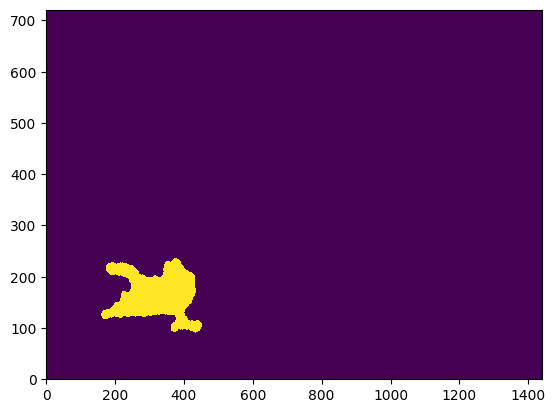

In [38]:
plt.pcolor(blob_id_time_p1 == 130)

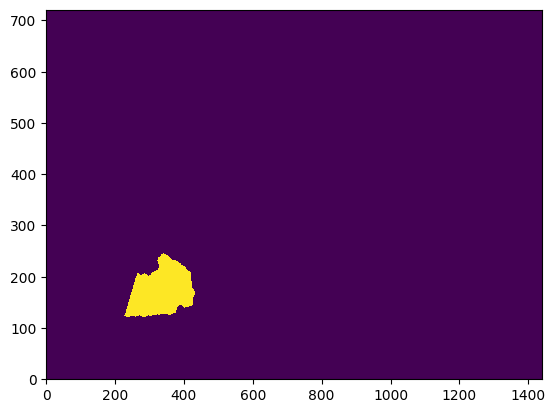

In [39]:
plt.pcolor(blob_id_time == 120)

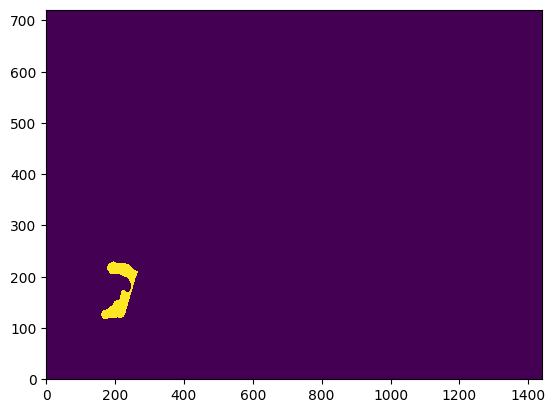

In [40]:
plt.pcolor(blob_id_time == 980)

In [41]:
blob_id_time_m1 = chunk_data.isel({tracker.timedim: relative_time_idx-1})

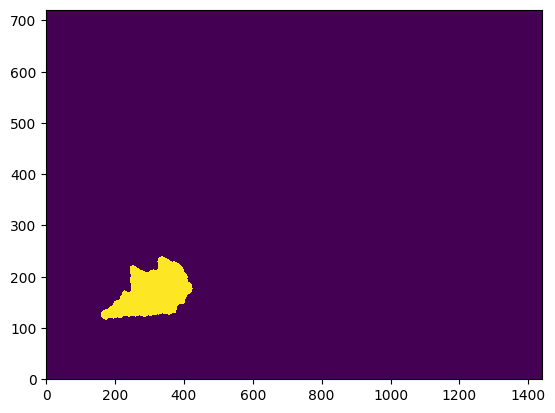

In [42]:
plt.pcolor(blob_id_time_m1 == 107)

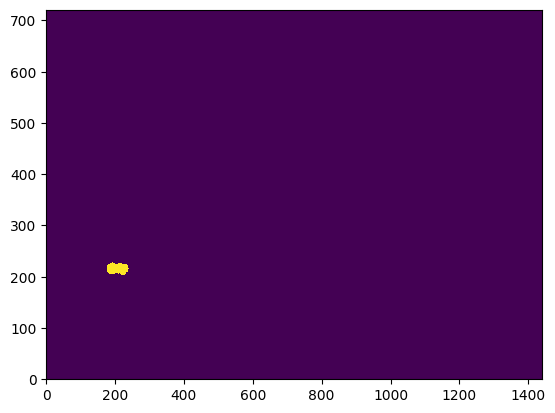

In [43]:
plt.pcolor(blob_id_time_m1 == 109)

In [ ]:


def map_IDs_to_indices(block, ID_to_cluster_index_array):
    mask = block > 0
    new_block = np.zeros_like(block, dtype=np.int32)
    new_block[mask] = ID_to_cluster_index_array[block[mask]]
    return new_block

split_merged_relabeled_blob_id_field = xr.apply_ufunc(
    map_IDs_to_indices,
    blob_id_field_unique, 
    ID_to_cluster_index_da,
    input_core_dims=[[tracker.ydim, tracker.xdim],['ID']],
    output_core_dims=[[tracker.ydim, tracker.xdim]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.int32]
)

In [ ]:
(split_merged_relabeled_blob_id_field == 1).any(dim={'lat','lon'}).plot()

In [ ]:
### Relabel the blobs_props to match the new IDs (and add time dimension!)

max_new_ID = num_components + 1  # New IDs range from 0 to max_new_ID...
new_ids = np.arange(1, max_new_ID+1, dtype=np.int32)

# New blobs_props DataSet Structure
blobs_props_extended = xr.Dataset(coords={
    'ID': new_ids,
    tracker.timedim: blob_id_field_unique[tracker.timedim]
})

In [ ]:
valid_new_ids = (split_merged_relabeled_blob_id_field > 0)      
original_ids = blob_id_field_unique.where(valid_new_ids, 0).stack(z=(tracker.ydim, tracker.xdim), create_index=False)
new_ids_field = split_merged_relabeled_blob_id_field.where(valid_new_ids, 0).stack(z=(tracker.ydim, tracker.xdim), create_index=False)

id_mapping = xr.Dataset({
    'original_id': original_ids,
    'new_id': new_ids_field
})

In [ ]:
# Create list to store DataArrays for each new_id
transformed_arrays = []
for new_id in new_ids:
    
    mask = id_mapping.new_id == new_id
    mask_time = mask.any('z')
    
    original_ids = id_mapping.original_id.where(mask, 0).max(dim='z').where(mask_time, 0)
    
    transformed_arrays.append(original_ids)

# Combine all arrays along new_id dimension
global_id_mapping = xr.concat(transformed_arrays, dim='new_id')
global_id_mapping = global_id_mapping.assign_coords(new_id=new_ids)

In [ ]:
new_id = 1
mask = id_mapping.new_id == new_id
mask_time = mask.any('z')

In [ ]:
global_id_mapping = xr.concat(transformed_arrays, dim='new_id').assign_coords(new_id=new_ids).rename({'new_id': 'ID'}).compute()


In [ ]:
blobs_props_extended['global_ID'] = global_id_mapping

In [ ]:
dummy = blobs_props.isel(ID=0) * np.nan
blobs_props = xr.concat([dummy.assign_coords(ID=0), blobs_props], dim='ID')

In [ ]:
for var_name in blobs_props.data_vars:
    
    blobs_props_extended[var_name] = (blobs_props[var_name]
                        .sel(ID=global_id_mapping.rename({'ID':'new_id'}))
                        .drop_vars('ID').rename({'new_id':'ID'}))

In [ ]:
valid_presence = blobs_props_extended['global_ID']>0  # Where we have valid data
valid_presence

In [ ]:
valid_presence.isel(ID=0).plot()

In [ ]:
# Cluster Blobs List to Determine Globally Unique IDs & Update Blob ID Field
split_merged_blobs_ds = tracker.cluster_rename_blobs_and_props(split_merged_blob_id_field_unique, merged_blobs_props, split_merged_blobs_list)

In [ ]:
# Add Merge Ledger to split_merged_blobs_ds
split_merged_blobs_ds.attrs['merge_ledger'] = merged_blobs_ledger

# Count Number of Blobs (This may have increased due to splitting)
N_blobs = split_merged_blobs_ds.ID_field.max().compute().data

In [ ]:
blobs.attrs

In [ ]:
# Save Tracked Blobs

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked.nc'
blobs.to_netcdf(file_name, mode='w')